In [1]:
import sys
sys.path.append('/Users/kk/code/pyrobo/src//')

In [2]:
import eLabPeersRobo


In [9]:
robot = eLabPeersRobo.init_robo()

http://robot.local:8888/robot/1350/1460/1390/1450/1500/1800/
1350/1460/1390/1450/1500


In [ ]:
robot.open_claw()

In [ ]:
robot.fkine([0,0,0,0,0])[:,3]

### Robot pickup marker and drop in box demo

In [10]:
import time
robot.open_claw()
robot.move_to((180,-15,-30))
time.sleep(3)
robot.close_claw()
robot.move_to((175,0,300))
robot.move_to((150,195,120))
robot.open_claw()
robot.move_to((175,0,300))


http://robot.local:8888/robot/1350/1460/1390/1450/1500/1300/
1350/1460/1390/1450/1500
[-0.08314124 -0.99630098 -0.5341103  -0.05657542  0.        ]
[-0.00415706 -0.04981505 -0.02670552 -0.00282877  0.        ]
[0 0 0 0 0] Before
[-0.00415706 -0.04981505 -0.02670552 -0.00282877  0.        ] After
http://robot.local:8888/robot/1347/1428/1372/1448/1500/1300/
1347/1428/1372/1448/1500
[-0.00415706 -0.04981505 -0.02670552 -0.00282877  0.        ] Before
[-0.00831412 -0.0996301  -0.05341103 -0.00565754  0.        ] After
http://robot.local:8888/robot/1344/1396/1355/1446/1500/1300/
1344/1396/1355/1446/1500
[-0.00831412 -0.0996301  -0.05341103 -0.00565754  0.        ] Before
[-0.01247119 -0.14944515 -0.08011655 -0.00848631  0.        ] After
http://robot.local:8888/robot/1342/1364/1338/1444/1500/1300/
1342/1364/1338/1444/1500
[-0.01247119 -0.14944515 -0.08011655 -0.00848631  0.        ] Before
[-0.01662825 -0.1992602  -0.10682206 -0.01131508  0.        ] After
http://robot.local:8888/robot/1339

### Robot camera

In [27]:
import urllib2
from operator import mul
import numpy as np


col_sz = (480, 640, 3)
dep_sz = (480, 640)
cad_sz = (480, 640, 3)


def from_buffer(im_str, sz):
    f1 = np.fromstring(im_str, dtype=np.uint8)
    return f1.reshape(sz)    

def get_images():
    response=urllib2.urlopen('http://robot.local:8888/camera')
    col = from_buffer(response.read(reduce(mul, col_sz)), col_sz)
    dep = from_buffer(response.read(reduce(mul, dep_sz)), dep_sz)
    cad = from_buffer(response.read(reduce(mul, cad_sz)), cad_sz)
    response.close()
    return col, dep, cad


In [28]:
(col, dep, cad) = get_images()

In [23]:
%matplotlib inline

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [24]:
from matplotlib import pyplot as plt

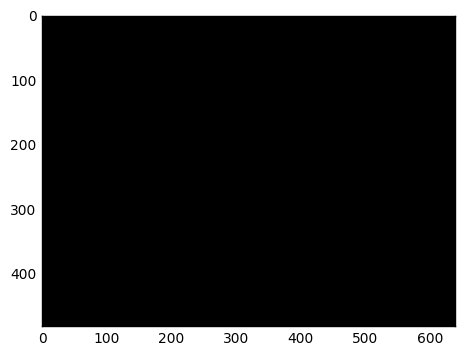

In [30]:
plt.imshow(cad)